In [1]:
from time import time
from matplotlib import pyplot as plt
import numpy as np

def active_set_method(A, b, epsilon):
    # Inicijalizacija neophodnih promenljvih
    m, n = A.shape
    P = []                   # Aktivni skup - na kraju ce sadrzati indekse atributa sadrzanih u resenju
    R = list(range(n))       # Neaktivni skup - sadrzi indekse atributa koje jos uvek nisu u resenju
    x = np.zeros(n)          # Aproksimacija resenja - inicajlno nula - iterativno se izgradjuje
    w = A.T @ (b - A @ x)    # Gradijent - meri koliko svaki atribut doprinosi smanjenju greske kada bi bio ukljucen u resenje
    
    # Sve dok R nije prazan i najveci doprinos je veci od tolerancije 
    while R and np.max(w[R]) > epsilon:
        # Izaberi atribut sa najvecim doprinosom i izbaci ga iz R i dodaj ga u P
        j = R[np.argmax(w[R])] 
        P.append(j)
        R.remove(j)

        # Resi problem metodom najmanjih kadvrata za matricu restrikovanu na atribute iz aktivnog skupa P
        AP = A[:, P]                                   # Restrikovano A
        s = np.zeros(n)                                # Tekuca aproksimacija - inicijalno nula
        s_P = np.linalg.pinv(AP.T @ AP) @ (AP.T @ b)   # Racunamo resenje problema
        s[P] = s_P                                     # Upisujemo resenje u konacnu aproksimaciju

        # Provera da li je resenje validno tj da li su sve koordinate vece od 0
        while np.min(s[P]) <= 0:
            # Ako nisu onda se aproksimacija koriguje

            # Racunamo korak alpha koji ce aproksimaciju pribliziti s tako da ne narusava uslov pozitivnosti
            alpha = np.nanmin(x[P] / (x[P] - s[P]))
            x = x + alpha * (s - x)

            # Atributi koji nisu postali nula idu u P 
            P = [i for i in P if x[i] > 0]
            # Oni koji jesu idu u R
            R = [i for i in range(n) if i not in P]

            # Azuriranja za sledecu iteraciju
            AP = A[:, P]
            s_P = np.linalg.pinv(AP.T @ AP) @ (AP.T @ b)
            s[P] = s_P

        # Ako jesu azurira se konacno resenje
        x = s  
       # print(x)

        # Azuriramo gradijentni vektor
        w = A.T @ (b - A @ x)

    return x

def fnnls(A,b,epsilon,maxiter=None,P_initial = np.zeros(0, dtype=int)): # Support vektor kao opcioni parametar
    m,n = A.shape 
    ATA = A.T.dot(A) 
    ATb = A.T.dot(b)
    max_repetitions = 5 # Broj koliko puta ćemo dopustiti da se skup P ponovi 
    if maxiter==None:
        maxiter=3*n
    P = np.zeros(n,dtype=bool) # Boolean indexing za dodatnu efikasnost
    P[P_initial] = True 
    x = np.zeros(n)
    w = ATb - (ATA).dot(x) # Gradijentni vektor računamo ovako
    s = np.zeros(n)
    no_update = 0 
    iter = 0
    if P_initial.shape[0] != 0:

        s[P] = np.linalg.inv((ATA)[P][:,P]).dot((ATb)[P])
        x = s.clip(min=0)
    
    
    while (not np.all(P)) and np.max(w[~P]) > epsilon:
        iter+=1
        if iter==maxiter:
            return [x,res]
        current_P = P.copy()
        
        P[np.argmax(w * ~P)] = True
        
        s[P] = np.linalg.inv((ATA)[P][:,P]).dot((ATb)[P]) # s računamo ovako
        
        if np.any(P) and np.min(s[P]) <= epsilon:
            s,x,P = inner_loop(ATA,ATb,s,x,P,epsilon)
    
        x = s.copy()
        
        w=ATb - (ATA).dot(x)
        
        if(np.all(current_P == P)):
            no_update +=1
        else:
            no_update = 0
            
        if no_update >= max_repetitions: # Ukoliko smo dostigli limit izlazimo iz petlje
            break
            
    res = np.linalg.norm(b-A.dot(x)) # ||b-Ax||
    
    return [x,res]

def inner_loop(ATA,ATb,s,x,P,epsilon): # U ovu petlju se jako retko ulazi u praksi,
    # u proseku u 1.41% slucajeva
    q = P * (s<=epsilon)
    alpha = np.min(x[q]/ (x[q]-s[q]))
    
    x = x+alpha*(s-x)
    
    P[x<=epsilon] = False
    
    s[P] = np.linalg.inv((ATA)[P][:,P]).dot((ATb)[P])
    
    s[~P] = 0
    
    return s,x,P

# **Primene NNLS algoritma u računarskoj grafici**
<br>
<br>
NNLS algoritam ima različite primene u računarskoj grafici, posebno u problemima koji uključuju optimizaciju gde ograničenja obezbeđuju da rešenje mora biti ne-negativno. Neke od primena su:

**Dekompozicija boja:**
Cilj je dobiti zadatu boju koričćenjem linearne kombinacije osnovnih boja, uz uslov da su koeficijenti (težine) ne-negativni. Ova procedura se često koristi u mešanju boja, kreiranju paleta i obradu slika gde imamo unapred definisan skup osnovnih boja.
<br>
<br>



Target color:  [0.878 0.588 0.11 ]
Base colors weights:  [0.29  0.    0.11  0.588]
Reconstructed color:  [0.878 0.588 0.11 ]


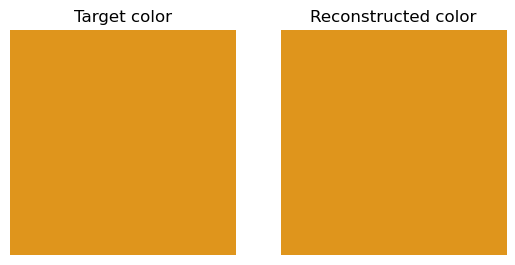



NNLS time: 

 0.012193441390991211





Target color:  [0.878 0.588 0.11 ]
Base colors weights:  [0.29  0.    0.11  0.588]
Reconstructed color:  [0.878 0.588 0.11 ]


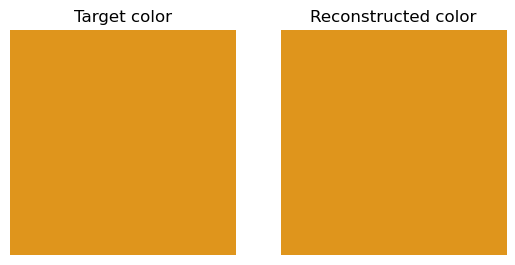



FNNLS time: 

 0.0


In [2]:
target_color = np.array([0.878,0.588,0.11]) # Neka nijansa narandzaste
base_colors = np.array([
    [1.0, 0.0, 0.0], # Crvena
    [0.0, 1.0, 0.0], # Zelena
    [0.0, 0.0, 1.0], # Plava
    [1.0, 1.0, 0.0], # Zuta
])

# NNLS
start = time()
coefs = active_set_method(base_colors.T,target_color,10**-5)
end = time()
nnls_time = end - start
reconstructed_color = coefs.dot(base_colors)
print("Target color: ", target_color)
print("Base colors weights: ", coefs)
print("Reconstructed color: ", reconstructed_color)

plt.subplot(1,2,1)
plt.title("Target color")
plt.imshow([[target_color]])
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstructed color")
plt.imshow([[reconstructed_color]])
plt.axis('off')
plt.show()

print("\n\nNNLS time: \n\n", nnls_time)
print("\n\n\n\n")

#FNNLS

start = time()
coefs, _ = fnnls(base_colors.T,target_color,10**-5)
end = time()
fnnls_time = end - start
reconstructed_color = coefs.dot(base_colors)
print("Target color: ", target_color)
print("Base colors weights: ", coefs)
print("Reconstructed color: ", reconstructed_color)

plt.subplot(1,2,1)
plt.title("Target color")
plt.imshow([[target_color]])
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstructed color")
plt.imshow([[reconstructed_color]])
plt.axis('off')
plt.show()

print("\n\nFNNLS time: \n\n", fnnls_time)



**Razdvajanje senke i osvetljenja:**
<br>
Veoma je bitno u zadacima kao sto su: 
<br>
Popravljanje vidljivosti detalja u osencenim regijama, identifikacija objekata na osnovu njihovih pravih boja i tekstura, nezavisno od osvetljenja, editovanje slika itd.

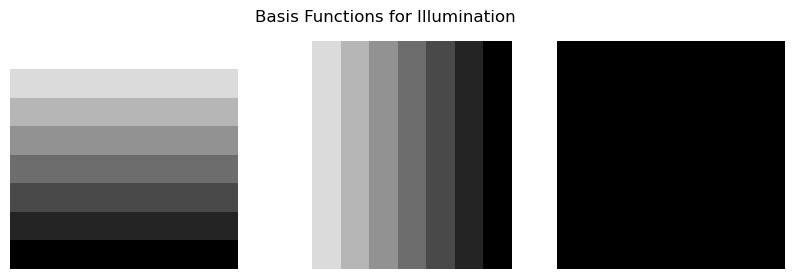

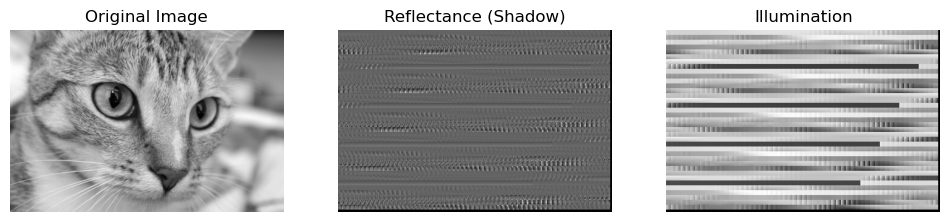

Standard NNLS time:  19.648519039154053


In [4]:
from skimage import color, data, img_as_float
from skimage.util import view_as_windows


image = color.rgb2gray(img_as_float(data.chelsea()))  # Učitavanje slike i konvertovanje u sivo
image = np.clip(image, 0.01, 0.99)  # vrednosti piksela postavljamo na vrednosti iz [0.01, 0.99]
# da izbegnemo jako tamne i jako svetle regije


block_size = (8, 8) # slika se deli na blokove veličine 8x8


patches = view_as_windows(image, block_size) # Izdvajanje zakrpa koriscenjem klizajućeg prozora
patches = patches.reshape(-1, block_size[0], block_size[1])

# Definisanje baznih funkcija 
basis_illumination = np.array([
    np.outer(np.linspace(1, 0, block_size[0]), np.ones(block_size[1])), 
    np.outer(np.ones(block_size[0]), np.linspace(1, 0, block_size[1])), 
    np.ones(block_size)  
])


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, basis in zip(axes.ravel(), basis_illumination):
    ax.imshow(basis, cmap='gray')
    ax.axis('off')
plt.suptitle("Basis Functions for Illumination")
plt.show()


flattened_patches = patches.reshape(patches.shape[0], -1)
flattened_basis_illumination = basis_illumination.reshape(basis_illumination.shape[0], -1)



illumination_weights = np.zeros((flattened_patches.shape[0], len(flattened_basis_illumination)))
reflectance_patches = np.zeros_like(flattened_patches)
start = time()

#PRIMENA NNLS:
    # Prolazimo kroz svaku zakrpu i primenjujemo NNLS da bismo dobili težine za bazne funkcije
    # Te težine se koriste da se rekonstruiše osvetljenje za svaku zakrpu
    # Senke se dobiju tako što podelimo originalnu zakrpu sa rekonstruisanim osvetljenjem

for i in range(flattened_patches.shape[0]):
    illumination_weights[i] = active_set_method(flattened_basis_illumination.T, flattened_patches[i],10**-3)
    reconstructed_illumination = np.dot(illumination_weights[i], flattened_basis_illumination)
    reflectance_patches[i] = flattened_patches[i] / (reconstructed_illumination + 1e-6)
end = time()

reflectance_patches = reflectance_patches.reshape(-1, block_size[0], block_size[1])



# Zakrpe senki se vraćaju u format 8x8 i onda stavljaju u rekonstruisanu sliku 
reconstructed_reflectance = np.zeros(image.shape)
patch_counts = np.zeros(image.shape)

patch_idx = 0
for i in range(0, image.shape[0] - block_size[0] + 1, block_size[0]):
    for j in range(0, image.shape[1] - block_size[1] + 1, block_size[1]):
        reconstructed_reflectance[i:i + block_size[0], j:j + block_size[1]] += reflectance_patches[patch_idx]
        patch_counts[i:i + block_size[0], j:j + block_size[1]] += 1
        patch_idx += 1


# Slično za osvetljenje...
reconstructed_illumination = np.zeros(image.shape)

patch_idx = 0
for i in range(0, image.shape[0] - block_size[0] + 1, block_size[0]):
    for j in range(0, image.shape[1] - block_size[1] + 1, block_size[1]):
        illum_patch = np.dot(illumination_weights[patch_idx], flattened_basis_illumination)
        reconstructed_illumination[i:i + block_size[0], j:j + block_size[1]] += illum_patch.reshape(block_size)
        patch_idx += 1




plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_reflectance, cmap='gray')
plt.title("Reflectance (Shadow)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_illumination, cmap='gray')
plt.title("Illumination")
plt.axis('off')

plt.show()

print("Standard NNLS time: ", end - start)


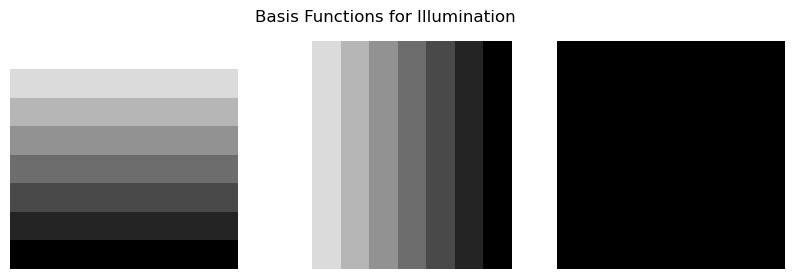

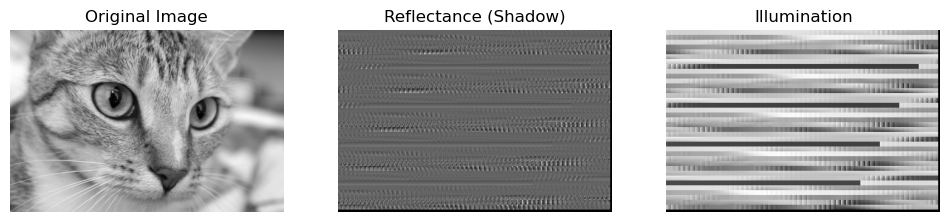

FNNLS time:  14.723403692245483


In [5]:
from skimage import color, data, img_as_float
from skimage.util import view_as_windows


image = color.rgb2gray(img_as_float(data.chelsea()))  
image = np.clip(image, 0.01, 0.99)  


block_size = (8, 8)


patches = view_as_windows(image, block_size)
patches = patches.reshape(-1, block_size[0], block_size[1])


basis_illumination = np.array([
    np.outer(np.linspace(1, 0, block_size[0]), np.ones(block_size[1])), 
    np.outer(np.ones(block_size[0]), np.linspace(1, 0, block_size[1])), 
    np.ones(block_size)  
])


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, basis in zip(axes.ravel(), basis_illumination):
    ax.imshow(basis, cmap='gray')
    ax.axis('off')
plt.suptitle("Basis Functions for Illumination")
plt.show()


flattened_patches = patches.reshape(patches.shape[0], -1)
flattened_basis_illumination = basis_illumination.reshape(basis_illumination.shape[0], -1)


illumination_weights = np.zeros((flattened_patches.shape[0], len(flattened_basis_illumination)))
reflectance_patches = np.zeros_like(flattened_patches)
start = time()
for i in range(flattened_patches.shape[0]):
    illumination_weights[i], _ = fnnls(flattened_basis_illumination.T, flattened_patches[i],10**-3)
    reconstructed_illumination = np.dot(illumination_weights[i], flattened_basis_illumination)
    reflectance_patches[i] = flattened_patches[i] / (reconstructed_illumination + 1e-6)
end = time()

reflectance_patches = reflectance_patches.reshape(-1, block_size[0], block_size[1])


reconstructed_reflectance = np.zeros(image.shape)
patch_counts = np.zeros(image.shape)

patch_idx = 0
for i in range(0, image.shape[0] - block_size[0] + 1, block_size[0]):
    for j in range(0, image.shape[1] - block_size[1] + 1, block_size[1]):
        reconstructed_reflectance[i:i + block_size[0], j:j + block_size[1]] += reflectance_patches[patch_idx]
        patch_counts[i:i + block_size[0], j:j + block_size[1]] += 1
        patch_idx += 1



reconstructed_illumination = np.zeros(image.shape)

patch_idx = 0
for i in range(0, image.shape[0] - block_size[0] + 1, block_size[0]):
    for j in range(0, image.shape[1] - block_size[1] + 1, block_size[1]):
        illum_patch = np.dot(illumination_weights[patch_idx], flattened_basis_illumination)
        reconstructed_illumination[i:i + block_size[0], j:j + block_size[1]] += illum_patch.reshape(block_size)
        patch_idx += 1



plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_reflectance, cmap='gray')
plt.title("Reflectance (Shadow)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_illumination, cmap='gray')
plt.title("Illumination")
plt.axis('off')

plt.show()

print("FNNLS time: ", end - start)

**Poređenje NNLS i FNNLS i vizualizacija:**

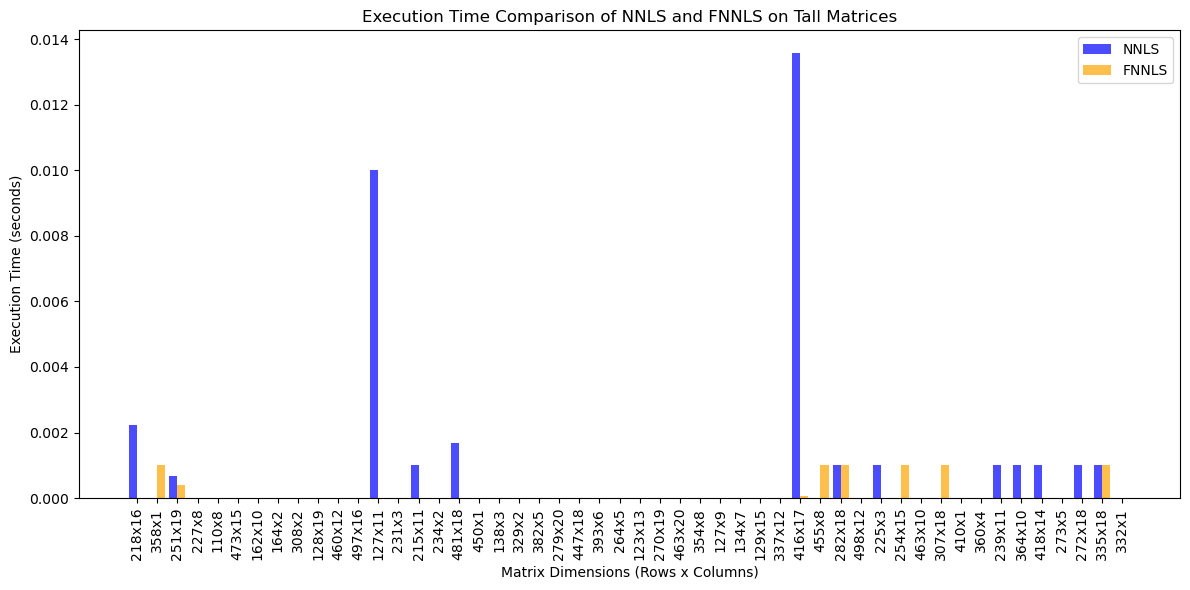

Average execution time for NNLS: 0.000723 seconds
Average execution time for FNNLS: 0.000129 seconds


In [7]:

num_matrices = 50  
rows = np.random.randint(100, 500, size=num_matrices)  
cols = np.random.randint(1, 21, size=num_matrices)        

execution_times_nnls = []
execution_times_fnnls = []


for i in range(num_matrices):
    m = rows[i]
    n = cols[i]
    
    matrix = np.random.uniform(-100.0, 100.0, (m, n))
    vector = np.random.uniform(-100.0, 100.0, m)
 
    start_time = time()
    active_set_method(matrix,vector,10**-3)
    end_time = time()
    execution_time_nnls = end_time - start_time
    execution_times_nnls.append(execution_time_nnls)
    
   
    start_time = time()
    fnnls(matrix,vector,10**-3)
    end_time = time()
    execution_time_fnnls = end_time - start_time
    execution_times_fnnls.append(execution_time_fnnls)


execution_times_nnls = np.array(execution_times_nnls)
execution_times_fnnls = np.array(execution_times_fnnls)


matrix_dimensions = [f"{rows[i]}x{cols[i]}" for i in range(num_matrices)]


plt.figure(figsize=(12, 6))
x_indices = np.arange(num_matrices)

plt.bar(x_indices - 0.2, execution_times_nnls, width=0.4, label='NNLS', color='blue', alpha=0.7)
plt.bar(x_indices + 0.2, execution_times_fnnls, width=0.4, label='FNNLS', color='orange', alpha=0.7)

plt.xlabel('Matrix Dimensions (Rows x Columns)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison of NNLS and FNNLS on Tall Matrices')
plt.xticks(x_indices, matrix_dimensions, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


average_time_nnls = np.mean(execution_times_nnls)
average_time_fnnls = np.mean(execution_times_fnnls)

print(f"Average execution time for NNLS: {average_time_nnls:.6f} seconds")
print(f"Average execution time for FNNLS: {average_time_fnnls:.6f} seconds")